In [104]:
import csv
import math
import json
import os
import cv2

from PIL import Image, ImageDraw, ImageFont
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape, Flatten, Dropout, Dense, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, GlobalAveragePooling2D, UpSampling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon
from tensorflow.keras.optimizers import Adam
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:80% !important; }</style>"))

### Preprocessing ###
Building up our training set, validation set and images from Pascal 2007 dataset.


[Multitask learn](https://towardsdatascience.com/multitask-learning-teach-your-ai-more-to-make-it-better-dde116c2cd40)

[Transfer learn](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a)

In [2]:
path = os.getcwd()
model_path = os.path.join(os.getcwd(), "models")
dataset_path = os.path.join(os.getcwd(), "dataset/Annotations")
image_path = os.path.join(os.getcwd(), "dataset/JPEGImages")

train_path = os.path.join(dataset_path, "pascal_train2007.json")
val_path = os.path.join(dataset_path, "pascal_val2007.json")

# building up training dataset
with open(train_path) as f:
    train_data = json.load(f)

train_dataset = []
for image in train_data["images"]:
    image_set = {}
    image_set["image"] = image
    
    anno_list = []
    for anno in train_data["annotations"]:
        if anno["image_id"] == image['id']:
            anno_list.append(anno)
    image_set["annotation"] = sorted(anno_list, key=lambda x:x["area"], reverse=True)[0]
    train_dataset.append(image_set)


# building up validation dataset    
with open(val_path) as f:
    val_data = json.load(f)
    
val_dataset = []
for image in val_data["images"]:
    image_set = {}
    image_set["image"] = image
    
    anno_list = []
    for anno in val_data["annotations"]:
        if anno["image_id"] == image["id"]:
            anno_list.append(anno)
    image_set["annotation"] = sorted(anno_list, key=lambda x:x["area"], reverse=True)[0]
    val_dataset.append(image_set)

# redistribute list
combine_list = train_dataset + val_dataset
train_dataset = combine_list[:int(len(combine_list) * 0.8)]
val_dataset = combine_list[int(len(combine_list) * 0.8):]
    
# converter to convert id to label name
id_to_name = {c['id']:c['name'] for c in train_data['categories']}

print(train_data.keys())
print()
print("images: {}\n".format(train_data['images'][0]))
print("annotations: {}\n".format(train_data['annotations'][0]))
print("categories: {}\n".format(train_data['categories'][0]))

dict_keys(['images', 'type', 'categories', 'annotations'])

images: {'id': 12, 'width': 500, 'file_name': '000012.jpg', 'height': 333}

annotations: {'id': 1, 'bbox': [155, 96, 196, 174], 'ignore': 0, 'iscrowd': 0, 'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]], 'image_id': 12, 'category_id': 7, 'area': 34104}

categories: {'name': 'aeroplane', 'supercategory': 'none', 'id': 1}



### Augmentation ###

In [3]:
import imgaug as ia
from imgaug import augmenters as iaa
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def show_img(im, figsize=(5, 5), dpi=100, ax=None, grey_scale=False):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    if grey_scale:
        ax.imshow(im, cmap='Greys_r')
    else:
        ax.imshow(im)
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    return ax

def aug_image(img):    
    # Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
    # e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)

    seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.2), # vertically flip 20% of all images                    
            
            # execute 0 to 2 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            iaa.SomeOf((0, 2),
                [
                    sometimes(iaa.Affine(rotate=(-45, 45))),
                    # sometimes(iaa.Superpixels(p_replace=(0, 0.3), n_segments=(0, 100))), # convert images into their superpixel representation
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                        iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                        iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                    # iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                    # search either for all edges or for directed edges,
                    # blend the result with the original image using a blobby mask
                    iaa.SimplexNoiseAlpha(iaa.OneOf([
                        iaa.EdgeDetect(alpha=(0.5, 1.0)),
                        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                    iaa.OneOf([
                        iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                        iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                    ]),
                    iaa.Invert(0.05, per_channel=True), # invert color channels
                    iaa.Add((0, 20), per_channel=0.5), # change brightness of images (by 0 to 20 of original value)
                    iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                    # either change the brightness of the whole image (sometimes
                    # per channel) or change the brightness of subareas
                    iaa.OneOf([
                        iaa.Multiply((0.5, 1.5), per_channel=0.5),
                        iaa.FrequencyNoiseAlpha(
                            exponent=(-4, 0),
                            first=iaa.Multiply((0.5, 1.5), per_channel=True),
                            second=iaa.ContrastNormalization((0.5, 2.0))
                        )
                    ]),
                    iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                    iaa.Grayscale(alpha=(0.0, 1.0)),
                    sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.04))), # sometimes move parts of the image around
                    # sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.05)))
                ],
                random_order=True
            )
        ],
        random_order=True
    )

    image_aug = seq.augment_images([img])[0]
    return image_aug

Visualise augmentation of image

(224, 224, 3)


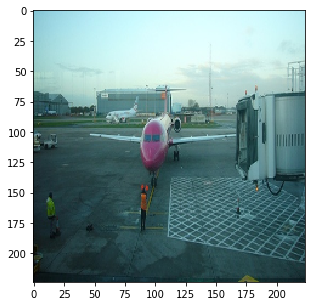

In [39]:
IMAGE_SIZE = 224
img_path = os.path.join(image_path, train_data["images"][4]['file_name'])

img = cv2.imread(img_path, 1)
img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  
img = img[..., ::-1]
img = aug_image(img)

print(img.shape)
show_img(img)

### Building classification model ###

In [40]:
# https://github.com/lars76/object-localization/blob/master/example_2/train.py
# determin percentage of MobileNetV2 will be used **Check later
ALPHA = 1.0

# training parameters
BATCH_SIZE = 64
IMAGE_SIZE = 224
EPOCHS = 200
PATIENCE = 50
MULTI_PROCESSING = False
THREADS = 3
NUM_CLASSES = 20

class DataGenerator(Sequence):

    def __init__(self, dataset, is_augmentated=False):
        self.is_augmentated = is_augmentated
        self.paths = []
        self.coords = np.zeros((len(dataset), 4 + NUM_CLASSES))
        
        for idx, data in enumerate(dataset):
            img_path = os.path.join(image_path, data["image"]['file_name'])
            self.paths.append(img_path)
            
            width = data["image"]["width"]
            height = data["image"]["height"]
        
            x_scale = IMAGE_SIZE / width
            y_scale = IMAGE_SIZE / height
            x0, y0, x1, y1 = data["annotation"]["bbox"]
            class_id = data["annotation"]["category_id"]
                        
            self.coords[idx, 0] = int(x0 * x_scale)
            self.coords[idx, 1] = int(y0 * y_scale)
            self.coords[idx, 2] = int(x1 * x_scale)
            self.coords[idx, 3] = int(y1 * y_scale)
            self.coords[idx, min(4 + int(class_id), self.coords.shape[1]-1)] = 1
            
    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)
    
    def __getitem__(self, idx):
        # Returns batch of images, [bbox, one-hot label]        
        # Select a batches from idx - batch_size
        # Sequence ensure idx is within of given dataset
        batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        
        batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        for i, f in enumerate(batch_paths):
            img = cv2.imread(f, 1)
            img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  
            img = img[..., ::-1]
            if self.is_augmentated:
                img = aug_image(img)            
                        
            batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
        return batch_images, batch_coords[..., 4:]


class Validation(Callback):
    def __init__(self, generator):
        self.generator = generator
    
    def on_epoch_end(self, epoch, logs):
        accuracy = 0        
        
        for i in range(len(self.generator)):
            batch_images, class_id = self.generator[i]
            pred_class = self.model.predict_on_batch(batch_images)
            
            # cal accuracy of pred_class
            pred_class = np.argmax(pred_class, axis=1)
            accuracy += np.sum(np.argmax(class_id, axis=1) == pred_class)

        accuracy = np.round(accuracy / len(self.generator.coords), 4)
        logs["val_acc"] = accuracy
        print("- val_acc: {}".format(accuracy))
    
def create_model(trainable=False):
    # transfer learn
    model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA)
    
    # freeze layers
    for layer in model.layers:
        layer.trainable = trainable
        
    # fine tune model
    x = model.output    
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(NUM_CLASSES, name="dense_classes", activation="softmax")(x)
    
    return Model(inputs=model.input, outputs=x)
    

In [10]:
model = create_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [12]:
train_datagen = DataGenerator(train_dataset, is_augmentated=True)
val_datagen = Validation(generator=DataGenerator(val_dataset, is_augmentated=True))

optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss={"dense_classes":"categorical_crossentropy"},
             loss_weights={"dense_classes":1}, optimizer=optimizer, metrics=['accuracy'])

checkpoint = ModelCheckpoint("model-{val_acc:.2f}.h5", monitor="val_acc", verbose=1, save_best_only=True, 
                             save_weights_only=True, mode="max", period=1)
earlystop = EarlyStopping(monitor="val_acc", patience=PATIENCE, mode="max")
reduce_lr = ReduceLROnPlateau(monitor="val_acc", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")

history = model.fit_generator(generator=train_datagen,
                    epochs=EPOCHS,
                    callbacks=[val_datagen, checkpoint, reduce_lr, earlystop],
                    workers=THREADS,
                    use_multiprocessing=MULTI_PROCESSING,
                    shuffle=True,
                    verbose=1)

Epoch 1/200
62/63 [============================>.] - ETA: 0s - loss: 2.8585 - acc: 0.1756- val_acc: 0.2512

Epoch 00001: val_acc improved from -inf to 0.25120, saving model to model-0.25.h5
63/63 [==============================] - 41s 646ms/step - loss: 2.8552 - acc: 0.1770
Epoch 2/200
62/63 [============================>.] - ETA: 0s - loss: 2.5762 - acc: 0.2586- val_acc: 0.2822

Epoch 00002: val_acc improved from 0.25120 to 0.28220, saving model to model-0.28.h5
63/63 [==============================] - 30s 472ms/step - loss: 2.5738 - acc: 0.2589
Epoch 3/200
62/63 [============================>.] - ETA: 0s - loss: 2.4373 - acc: 0.2915- val_acc: 0.3509

Epoch 00003: val_acc improved from 0.28220 to 0.35090, saving model to model-0.35.h5
63/63 [==============================] - 30s 473ms/step - loss: 2.4320 - acc: 0.2924
Epoch 4/200
62/63 [============================>.] - ETA: 0s - loss: 2.2775 - acc: 0.3239- val_acc: 0.3938

Epoch 00004: val_acc improved from 0.35090 to 0.39380, saving

Epoch 33/200
62/63 [============================>.] - ETA: 0s - loss: 1.3731 - acc: 0.5957- val_acc: 0.6381

Epoch 00033: val_acc improved from 0.63410 to 0.63810, saving model to model-0.64.h5
63/63 [==============================] - 29s 467ms/step - loss: 1.3744 - acc: 0.5964
Epoch 34/200
62/63 [============================>.] - ETA: 0s - loss: 1.3852 - acc: 0.5859- val_acc: 0.6321

Epoch 00034: val_acc did not improve from 0.63810
63/63 [==============================] - 30s 472ms/step - loss: 1.3828 - acc: 0.5863
Epoch 35/200
62/63 [============================>.] - ETA: 0s - loss: 1.3609 - acc: 0.5894- val_acc: 0.6361

Epoch 00035: val_acc did not improve from 0.63810
63/63 [==============================] - 29s 462ms/step - loss: 1.3571 - acc: 0.5902
Epoch 36/200
62/63 [============================>.] - ETA: 0s - loss: 1.3428 - acc: 0.5955- val_acc: 0.6271

Epoch 00036: val_acc did not improve from 0.63810
63/63 [==============================] - 30s 476ms/step - loss: 1.3418 - a

Epoch 66/200
62/63 [============================>.] - ETA: 0s - loss: 1.2147 - acc: 0.6321- val_acc: 0.658

Epoch 00066: val_acc did not improve from 0.67600
63/63 [==============================] - 29s 457ms/step - loss: 1.2110 - acc: 0.6342
Epoch 67/200
62/63 [============================>.] - ETA: 0s - loss: 1.1801 - acc: 0.6521- val_acc: 0.673

Epoch 00067: val_acc did not improve from 0.67600
63/63 [==============================] - 30s 471ms/step - loss: 1.1810 - acc: 0.6519
Epoch 68/200
62/63 [============================>.] - ETA: 0s - loss: 1.1780 - acc: 0.6540- val_acc: 0.653

Epoch 00068: val_acc did not improve from 0.67600
63/63 [==============================] - 30s 476ms/step - loss: 1.1790 - acc: 0.6523
Epoch 69/200
62/63 [============================>.] - ETA: 0s - loss: 1.1588 - acc: 0.6590- val_acc: 0.665

Epoch 00069: val_acc did not improve from 0.67600
63/63 [==============================] - 29s 467ms/step - loss: 1.1589 - acc: 0.6585
Epoch 70/200
62/63 [========

Epoch 99/200
62/63 [============================>.] - ETA: 0s - loss: 1.1173 - acc: 0.6573- val_acc: 0.6431

Epoch 00099: val_acc did not improve from 0.69090
63/63 [==============================] - 29s 466ms/step - loss: 1.1216 - acc: 0.6568
Epoch 100/200
62/63 [============================>.] - ETA: 0s - loss: 1.1633 - acc: 0.6516- val_acc: 0.6431

Epoch 00100: val_acc did not improve from 0.69090
63/63 [==============================] - 29s 463ms/step - loss: 1.1613 - acc: 0.6519
Epoch 101/200
62/63 [============================>.] - ETA: 0s - loss: 1.1559 - acc: 0.6525- val_acc: 0.668

Epoch 00101: val_acc did not improve from 0.69090

Epoch 00101: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
63/63 [==============================] - 29s 453ms/step - loss: 1.1574 - acc: 0.6520
Epoch 102/200
62/63 [============================>.] - ETA: 0s - loss: 1.1274 - acc: 0.6577- val_acc: 0.664

Epoch 00102: val_acc did not improve from 0.69090
63/63 [===================

Epoch 132/200
62/63 [============================>.] - ETA: 0s - loss: 1.1655 - acc: 0.6501- val_acc: 0.661

Epoch 00132: val_acc did not improve from 0.69090
63/63 [==============================] - 30s 475ms/step - loss: 1.1650 - acc: 0.6504
Epoch 133/200
62/63 [============================>.] - ETA: 0s - loss: 1.1363 - acc: 0.6595- val_acc: 0.654

Epoch 00133: val_acc did not improve from 0.69090
63/63 [==============================] - 30s 477ms/step - loss: 1.1355 - acc: 0.6595
Epoch 134/200
62/63 [============================>.] - ETA: 0s - loss: 1.1724 - acc: 0.6551- val_acc: 0.652

Epoch 00134: val_acc did not improve from 0.69090
63/63 [==============================] - 30s 475ms/step - loss: 1.1726 - acc: 0.6544
Epoch 135/200
62/63 [============================>.] - ETA: 0s - loss: 1.1454 - acc: 0.6573- val_acc: 0.658

Epoch 00135: val_acc did not improve from 0.69090
63/63 [==============================] - 29s 462ms/step - loss: 1.1463 - acc: 0.6558
Epoch 136/200
62/63 [===

In [13]:
print(history.history.keys())

dict_keys(['loss', 'lr', 'val_acc', 'acc'])


<Figure size 432x288 with 0 Axes>

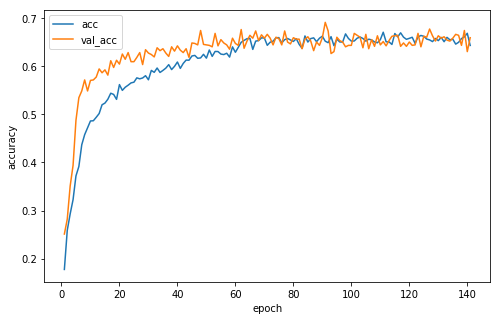

In [16]:
epochs = range(1, 142)

plt.figure()
plt.subplots(figsize=(8, 5))
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='best')
plt.show()

#### Why are we seeing test validate accuracy higher than train accuracy?

##### Understanding Dropout

Dropout(0.5) will force neural network to learn with 50% neural switch off. Think of Dropout we added to our model has force our neural network to become a collection of weak classifiers. These collection of classifier doesn't have much classification accuracy, they only become powerful once we bunch them together.


During early stage of training, Dropout kicks in forcing the network to learn with constrain and accuracy suffers. At testing phase, Dropout is turn off allow all of our "weak classifier" to be use and thus out perform training accuracy.

After 60 epoch, we could ensure that our model does not overfit and model had a final accuracy of 0.69

In usual example we see online, we have training accuracy higher than test accuracy but for this case it is the opposite. This happens occasionally. We could try using a larger test set to see if this persist.

### Thresholding image ###

(224, 224)


array([[0.06681531, 0.06681531, 0.06681531, ..., 0.06681531, 0.06681531,
        0.06681531],
       [0.06681531, 0.06681531, 0.06681531, ..., 0.06681531, 0.06681531,
        0.06681531],
       [0.06681531, 0.06681531, 0.06681531, ..., 0.06681531, 0.06681531,
        0.06681531],
       ...,
       [0.09166985, 0.09166985, 0.09166985, ..., 0.        , 0.        ,
        0.        ],
       [0.08980265, 0.08980265, 0.08980265, ..., 0.        , 0.        ,
        0.        ],
       [0.08512565, 0.08512565, 0.08512565, ..., 0.        , 0.        ,
        0.08512565]])

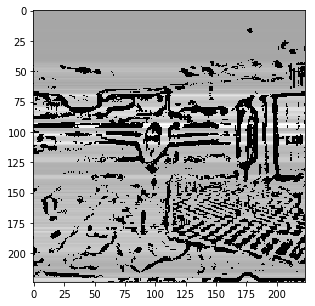

In [45]:
from sklearn.preprocessing import normalize

def thresh_img(img_path, show=False):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  
    img = cv2.medianBlur(img, 5)
    th3 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)    
    th3 = normalize(th3)
    if show:
        show_img(th3, grey_scale=True)
        print(th3.shape)
    return th3


img_path = os.path.join(image_path, train_data["images"][4]['file_name'])
thresh_img(img_path, show=True)

### Using Fourier Transformation on image

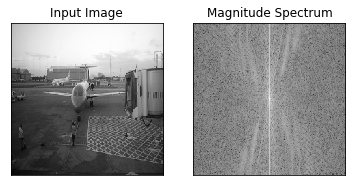

(224, 224)


array([[0.05128587, 0.06424068, 0.0601232 , ..., 0.0595615 , 0.0601232 ,
        0.06424068],
       [0.07207116, 0.05801561, 0.04775312, ..., 0.06050272, 0.05401253,
        0.0684045 ],
       [0.06868227, 0.06179065, 0.06469056, ..., 0.05258901, 0.06096751,
        0.06321216],
       ...,
       [0.06298802, 0.06536797, 0.06495323, ..., 0.04508789, 0.06631253,
        0.05227754],
       [0.06868228, 0.06321217, 0.06096752, ..., 0.06265174, 0.06469057,
        0.06179065],
       [0.07207116, 0.0684045 , 0.05401253, ..., 0.06134144, 0.04775312,
        0.05801561]], dtype=float32)

In [42]:
def fft_img(img_path, show=False):
    img = cv2.imread(img_path, 0)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  
    
    dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))
    magnitude_spectrum = normalize(magnitude_spectrum)    

    if show:
        plt.subplot(121), plt.imshow(img, cmap='gray')
        plt.title('Input Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
        plt.show()

        print(magnitude_spectrum.shape)   
    return magnitude_spectrum

img_path = os.path.join(image_path, train_data["images"][4]['file_name'])
fft_img(img_path, True)

### Experimential

Not sure if this is gonna work but I have an idea.
Imagine an image we have 3 layers RGB, to machine this correspond same image with only color difference. For us human we could still recognise an object even with a single color layer. It doesn't provide model additional information to learn for classification case.

I would like to provide model with additional information for it to learn. It is like adding layer informations to discover of correlation between different dataset.
For this case, I provide image threshing and magnitude spectrum from FFT. Hopefully it will allow model to learn extra correlation from these new datset.

In [108]:
IMAGE_SIZE = 224
img_path = os.path.join(image_path, train_data["images"][5]['file_name'])

img = cv2.imread(img_path, 1)
img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  
img = img[..., ::-1]

# img.append(thresh_img(img_path))
# img.concatenate(fft_img(img_path))

print(thresh_img(img_path).shape)

# show_img(img)

(224, 224)


In [94]:
# https://github.com/lars76/object-localization/blob/master/example_2/train.py
# determin percentage of MobileNetV2 will be used **Check later
ALPHA = 1.0

# training parameters
BATCH_SIZE = 64
IMAGE_SIZE = 224
EPOCHS = 200
PATIENCE = 50
MULTI_PROCESSING = False
THREADS = 3
NUM_CLASSES = 20

class DataGenerator(Sequence):

    def __init__(self, dataset, is_augmentated=False):
        self.is_augmentated = is_augmentated
        self.paths = []
        self.coords = np.zeros((len(dataset), 4 + NUM_CLASSES))
        
        for idx, data in enumerate(dataset):
            img_path = os.path.join(image_path, data["image"]['file_name'])
            self.paths.append(img_path)
            
            width = data["image"]["width"]
            height = data["image"]["height"]
        
            x_scale = IMAGE_SIZE / width
            y_scale = IMAGE_SIZE / height
            x0, y0, x1, y1 = data["annotation"]["bbox"]
            class_id = data["annotation"]["category_id"]
                        
            self.coords[idx, 0] = int(x0 * x_scale)
            self.coords[idx, 1] = int(y0 * y_scale)
            self.coords[idx, 2] = int(x1 * x_scale)
            self.coords[idx, 3] = int(y1 * y_scale)
            self.coords[idx, min(4 + int(class_id), self.coords.shape[1]-1)] = 1
            
    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)
    
    def __getitem__(self, idx):
        # Returns batch of images, [bbox, one-hot label]        
        # Select a batches from idx - batch_size
        # Sequence ensure idx is within of given dataset
        batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        
        batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        for i, f in enumerate(batch_paths):            
            img = cv2.imread(img_path, 1)
            img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  
            img = img[..., ::-1]
            if self.is_augmentated:
                img = aug_image(img)   
            
            img[..., 1] = thresh_img(img_path)
            img[..., 2] = fft_img(img_path)
                                                 
            batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
        return batch_images, batch_coords[..., 4:]


class Validation(Callback):
    def __init__(self, generator):
        self.generator = generator
    
    def on_epoch_end(self, epoch, logs):
        accuracy = 0        
        
        for i in range(len(self.generator)):
            batch_images, class_id = self.generator[i]
            pred_class = self.model.predict_on_batch(batch_images)
            
            # cal accuracy of pred_class
            pred_class = np.argmax(pred_class, axis=1)
            accuracy += np.sum(np.argmax(class_id, axis=1) == pred_class)

        accuracy = np.round(accuracy / len(self.generator.coords), 4)
        logs["val_acc"] = accuracy
        print("- val_acc: {}".format(accuracy))
    
def create_model(trainable=False):
    # transfer learn
    model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA)
    
    # freeze layers
    for layer in model.layers[:-5]:
        layer.trainable = trainable
        
    # fine tune model
    x = model.output    
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(NUM_CLASSES, name="dense_classes", activation="softmax")(x)
    
    return Model(inputs=model.input, outputs=x)

In [95]:
model = create_model(trainable=False)

In [97]:
train_datagen = DataGenerator(train_dataset, is_augmentated=False)
val_datagen = Validation(generator=DataGenerator(val_dataset, is_augmentated=False))

optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss={"dense_classes":"categorical_crossentropy"},
             loss_weights={"dense_classes":1}, optimizer=optimizer, metrics=['accuracy'])

checkpoint = ModelCheckpoint("model-{val_acc:.2f}.h5", monitor="val_acc", verbose=1, save_best_only=True, 
                             save_weights_only=True, mode="max", period=1)
earlystop = EarlyStopping(monitor="val_acc", patience=PATIENCE, mode="max")
reduce_lr = ReduceLROnPlateau(monitor="val_acc", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")

history = model.fit_generator(generator=train_datagen,
                    epochs=EPOCHS,
                    callbacks=[val_datagen, checkpoint, reduce_lr, earlystop],
                    workers=THREADS,
                    use_multiprocessing=MULTI_PROCESSING,
                    shuffle=True,
                    verbose=1)

Epoch 1/200
62/63 [============================>.] - ETA: 0s - loss: 2.7073 - acc: 0.2176- val_acc: 0.1904

Epoch 00001: val_acc improved from -inf to 0.19040, saving model to model-0.19.h5
63/63 [==============================] - 25s 390ms/step - loss: 2.7072 - acc: 0.2182
Epoch 2/200
62/63 [============================>.] - ETA: 0s - loss: 2.7027 - acc: 0.2184- val_acc: 0.1904

Epoch 00002: val_acc did not improve from 0.19040
63/63 [==============================] - 18s 285ms/step - loss: 2.7018 - acc: 0.2184
Epoch 3/200
62/63 [============================>.] - ETA: 0s - loss: 2.6972 - acc: 0.2202- val_acc: 0.1904

Epoch 00003: val_acc did not improve from 0.19040
63/63 [==============================] - 18s 285ms/step - loss: 2.6995 - acc: 0.2184
Epoch 4/200
62/63 [============================>.] - ETA: 0s - loss: 2.7075 - acc: 0.2174- val_acc: 0.1904

Epoch 00004: val_acc did not improve from 0.19040
63/63 [==============================] - 18s 283ms/step - loss: 2.7046 - acc: 0.2

Epoch 34/200
62/63 [============================>.] - ETA: 0s - loss: 2.6864 - acc: 0.2192- val_acc: 0.1904

Epoch 00034: val_acc did not improve from 0.19040
63/63 [==============================] - 18s 285ms/step - loss: 2.6886 - acc: 0.2184
Epoch 35/200
62/63 [============================>.] - ETA: 0s - loss: 2.6929 - acc: 0.2194- val_acc: 0.1904

Epoch 00035: val_acc did not improve from 0.19040
63/63 [==============================] - 18s 283ms/step - loss: 2.6945 - acc: 0.2184
Epoch 36/200
62/63 [============================>.] - ETA: 0s - loss: 2.6908 - acc: 0.2186- val_acc: 0.1904

Epoch 00036: val_acc did not improve from 0.19040
63/63 [==============================] - 18s 285ms/step - loss: 2.6905 - acc: 0.2184
Epoch 37/200
62/63 [============================>.] - ETA: 0s - loss: 2.6914 - acc: 0.2166- val_acc: 0.1904

Epoch 00037: val_acc did not improve from 0.19040
63/63 [==============================] - 18s 283ms/step - loss: 2.6889 - acc: 0.2184
Epoch 38/200
62/63 [====